In [1]:
import os
from multiprocessing import Pool

import networkx as nx
import numpy as np

from src.vrp_study.pdptw_model.pdptw_routing_manager_builder import PDRoutingManagerBuilder
from src.vrp_study.pdptw_model.routing_model import find_optimal_paths
from src.vrp_study.data_loader import parse_data
from src.vrp_study.configs import ModelConfig
from vrp_study.data_model import Tariff, Cargo, Node
from vrp_study.routing_manager import RoutingManager
from src.vrp_study.pdptw_model.solution_builder import SolutionBuilder
import pickle

In [4]:
def func(du, dv):
    return np.sqrt((du[0] - dv[0]) ** 2 + (du[1] - dv[1]) ** 2)


def calc(data):
    u, du, p2coordinate = data
    return {(u, v): func(du, dv) for v, dv in p2coordinate.items()}


def rm(
        depo: Node,
        cargos: list[Cargo],
        tariff: Tariff,
        p: Pool
) -> RoutingManager:
    p2coordinates = {}

    p2coordinates.update({
        crg.nodes[i].id: crg.nodes[i].coordinates for crg in cargos for i in range(2)
    })
    p2coordinates[depo.id] = depo.coordinates

    res = list(p.imap_unordered(calc, [(u, du, p2coordinates) for u, du in p2coordinates.items()]))
    distance_matrix = {}
    time_matrix = {}
    for r in res:
        for k, v in r.items():
            distance_matrix[k] = v
            time_matrix[k] = v

    routing_manager = PDRoutingManagerBuilder(
        distance_matrix=distance_matrix,
        time_matrix=time_matrix,
        model_config=ModelConfig(max_execution_time_minutes=1)
    )

    routing_manager.add_cargos(cargos)
    routing_manager.add_tariff(tariff)

    routing_manager.add_depo(depo)

    routing_manager = routing_manager.build()
    return routing_manager

In [5]:
def rms_calc(data):
    routing_manager, benchmark_type, name = data
    sb = SolutionBuilder()
    cg = sb.generate_full_graph(routing_manager)
    
    with open(f'../data/graphs/{benchmark_type}_{name}_cg.pkl', 'wb') as f:
        pickle.dump(cg, f)

    sol = find_optimal_paths(routing_manager, sb)

    sols = []
    
    for s in sol[0]:
        if len(s) > 0:
            sols.append([i for i in s[1:-1]])
    with open(f'../data/results/{benchmark_type}_{name}.pkl', 'wb') as f:
        pickle.dump((sols, routing_manager), f)
    del routing_manager, benchmark_type, name, sol, sols


In [6]:
from tqdm import tqdm
from loguru import logger as log
log.remove()
NUM_WORKERS = 4
MAX_SIZE = 10 # создаем столько менеджеров. потом в парралель NUM_WORKERS  решают

with Pool(NUM_WORKERS ) as p:
    for benchmark_type in ['pdp_100']:#os.listdir('../data/Li & Lim benchmark'):
        rms = []
        for name in tqdm(os.listdir(f'../data/Li & Lim benchmark/{benchmark_type}')):
            depo, cargos, tariff = parse_data(f'../data/Li & Lim benchmark/{benchmark_type}/{name}')
            rms.append((rm(depo, cargos, tariff, p), benchmark_type, name))
            if len(rms) == MAX_SIZE:
                rr = list(p.imap_unordered(rms_calc, rms))
                rms = []
        break
    if len(rms) > 0:
        rr = list(p.imap_unordered(rms_calc, rms))
        rms = []

100%|██████████| 56/56 [02:27<00:00,  2.63s/it]


In [7]:
from vrp_study.pdptw_model.solution_checker import check_solution

for file_name in os.listdir('../data/graphs'):
    solution_name = file_name.replace('_cg','')
    with open(f'../data/results/{solution_name}','rb') as f:
        res = pickle.load(f)
    sols, rm = res
    rm: RoutingManager = rm
    assert check_solution(rm,sols)

In [15]:

for file_name in os.listdir('../data/graphs'):
    solution_name = file_name.replace('_cg','')
    print(file_name, solution_name)
    with open(f'../data/graphs/{file_name}','rb') as f:
        cg = pickle.load(f)
    with open(f'../data/results/{solution_name}','rb') as f:
        res = pickle.load(f)
    sols, rm = res
    rm: RoutingManager = rm
    cg: nx.DiGraph = cg
    # print(cg.edges())
    
    edges2remove = set()
    
    for u,v,d in cg.edges(data='length'):
        if d > 7:
            edges2remove.add((u,v))
    cg.remove_edges_from(edges2remove)
    
    
    for sol in sols:
        cargo_path_set = set()
        cargo_path = []
        for i in range(len(sol)):
            pdp = rm.nodes()[sol[i]].pdp_id
            if pdp not in cargo_path_set:
                cargo_path_set.add(pdp)
                cargo_path.append(pdp)
        print(sol)
        print(cargo_path)
        
        for i in range(len(cargo_path)-1):
            p1 = cargo_path[i]
            p2 = cargo_path[i+1]
            n1 = rm.get_pick_up_and_delivery_nodes()[p1][0]
            n2 = rm.get_pick_up_and_delivery_nodes()[p2][0]
            e = cg.edges()[n1,n2]
            print(e)

pdp_100_lrc204.txt_cg.pkl pdp_100_lrc204.txt.pkl
[73, 95, 33, 51, 31, 85, 35, 32, 74, 29, 37, 34, 30, 27, 55, 96, 86, 36, 45, 53, 52, 38, 47, 43, 46, 49, 48, 56, 28, 54, 50, 44]
[36, 47, 16, 25, 15, 42, 17, 14, 18, 13, 27, 22, 26, 23, 21, 24]
{'length': np.float64(0.8228306552571969), 'l_ab': 35.35533905932738, 'l_cd': 31.953090617340916, 'l0': 67.3184296766683, 'l1': 54.19100840863323, 't_ab': 35.35533905932738, 't_cd': 31.953090617340916, 't0': 67.3184296766683, 't1': 278, 'remainders': [942, 922, 856, 305]}
{'length': np.float64(0.8118694494267554), 'l_ab': 31.953090617340916, 'l_cd': 40.162171256046406, 'l0': 72.12526187338733, 'l1': 57.093222890176165, 't_ab': 31.953090617340916, 't_cd': 40.162171256046406, 't0': 72.12526187338733, 't1': 309, 'remainders': [937, 120, 333, 606]}
{'length': np.float64(1.3162448212632774), 'l_ab': 40.162171256046406, 'l_cd': 31.78049716414141, 'l0': 71.95266842018782, 'l1': 91.72402771346543, 't_ab': 40.162171256046406, 't_cd': 31.78049716414141, 't0

KeyError: 'The edge (99, 105) is not in the graph.'

In [10]:
cg

(array([ 10.,  21.,  28.,  42.,  44.,  68.,  87.,  97.,  81., 101.,  71.,
         79.,  76.,  60.,  61.,  51.,  43.,  52.,  48.,  60.,  41.,  42.,
         46.,  32.,  34.,  32.,  29.,  27.,  24.,  23.,  23.,  24.,  27.,
         22.,  19.,  14.,  15.,  18.,  17.,  18.,  14.,  14.,  16.,  16.,
          9.,   9.,  17.,  13.,   8.,  13.,   8.,   8.,   9.,  12.,   8.,
          6.,   6.,   5.,   4.,   4.,   4.,   7.,   5.,   7.,   6.,   4.,
          6.,   1.,   4.,   7.,   3.,   8.,   3.,   4.,   2.,   3.,   3.,
          4.,   1.,   5.,   1.,   5.,   1.,   3.,   2.,   2.,   3.,   1.,
          5.,   2.,   3.,   6.,   1.,   3.,   1.,   3.,   2.,   2.,   2.,
          1.]),
 array([0.6801737 , 0.74337025, 0.80656679, 0.86976334, 0.93295989,
        0.99615644, 1.05935299, 1.12254954, 1.18574609, 1.24894264,
        1.31213919, 1.37533574, 1.43853229, 1.50172884, 1.56492539,
        1.62812194, 1.69131849, 1.75451504, 1.81771159, 1.88090814,
        1.94410469, 2.00730124, 2.07049779, 2.

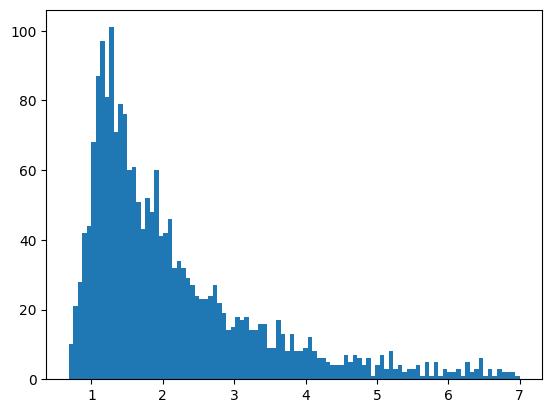

In [13]:
from matplotlib import pyplot as plt
edge_values = np.array([d['length'] for u,v,d in cg.edges(data=True)])
edge_values = edge_values[edge_values< 7]
plt.hist(edge_values,bins=100)

In [14]:
edge_values.min(), edge_values.max()

(np.float64(0.680173695454908), np.float64(6.999828659795264))